# Detection et traitement du Bruis

*a.k.a* Denoiser

Dans cette partie, nous allons étudier un système permettant de detecter et de réduire l'infulence du Bruis sur les images dégradés issues des VHS.

Les données d'entrée sont donc des images bruitées issues de la numérisation de VHS. La sortie attendue est la même image mais ayant un bruis atténué voir absent.

## Mise en place du Notebook

Ici, nous importons les différentes bibliothèques et définissions les constantes

In [2]:
import numpy as np
from PIL import Image
import matplotlib as plt
from skimage.util import random_noise
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import gaussian
from IPython.display import display
from os import listdir
from os.path import isfile, join
from sklearn.dummy import DummyRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from keras.models import Sequential
from keras.layers import Dense
from multiprocessing import Pool

Using TensorFlow backend.


In [26]:
%matplotlib inline
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
DATASETS_PATH = "../labs/noise-filter/"

source_path = DATASETS_PATH+"clean_base"
ref_out = DATASETS_PATH+"clean_splitted"
noise_out = DATASETS_PATH+"noisy_splitted"
isolated_out = DATASETS_PATH+"noisy_isolated"
NEIGHBOURS=20

Tout les datasets de ce notebooks seront stockés dans le dossier `Labs/noise-filter`

In [4]:
def show_img(imga):
    display(Image.fromarray(np.interp(imga,(0,1), (0,255)).astype("uint8")))

In [4]:
!rm -rf ../labs/noise-filter
!mkdir -p ../labs/noise-filter
!mkdir -p ../labs/noise-filter/clean_base
!cp -f ../dataset_clean_degraded/clean/* ../labs/noise-filter/clean_base
!mkdir -p ../labs/noise-filter/clean_splitted
!mkdir -p ../labs/noise-filter/noisy_splitted
!mkdir -p ../labs/noise-filter/noisy_isolated

# CRISP Itéraion 1

## Exploration des données

On peut alors tirer quelques images ayant du bruis

|                                  |                                  |
|----------------------------------|----------------------------------|
|![Image 1](../dataset/0001.jpg)   | ![Image 7](../dataset/0007.jpg)  |
|![Image 76](../dataset/0076.jpg)  | ![Image 180](../dataset/0180.jpg)|

On remarque alors que le bruis est dans tout ces cas, **sensiblement le même** : Un bruis en largeur ajoutant un grain noir à l'image.
Mais on remarque aussi que le bruis n'est **pas localisé** et donc qu'il est possible de simplement débruiter une portion de l'image sans avoir besoin d'apprécier le contexte général de l'image.
Enfin, on remarque que ces images contiennent aussi d'**autres problèmes** qui nous n'allons pas traiter ici mais qui devront être traités par un autre filtre.
On remarque aussi que l'ensemble des images 

## Data génération

Pour faciliter l'entrainement de notre algorithme, nous allons prendre les images clean données dans le dossier `clean_base`

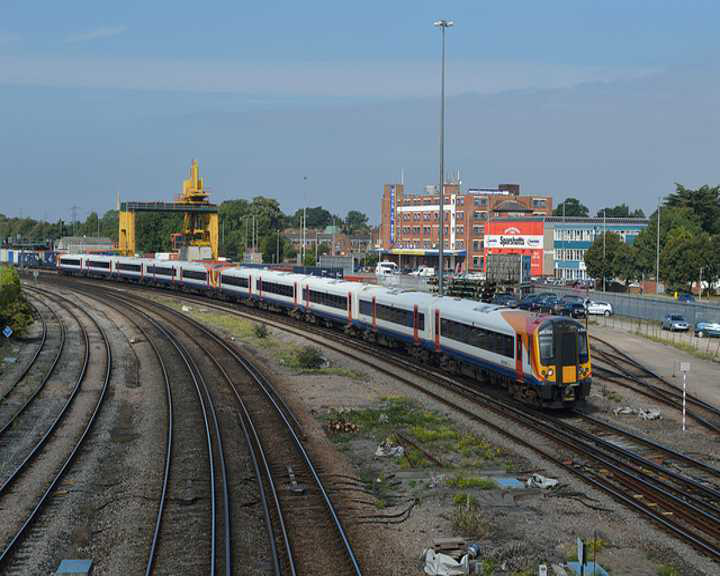

In [5]:
img = Image.open(DATASETS_PATH+"clean_base/000000000071.jpg")
img

In [5]:
def apply_noise(imga):
    imga = np.rot90(imga)

    imghla = rgb2hsv(imga)
    imgsat = imghla[:,:,2]
    imgsat = random_noise(imgsat,mode='gaussian', seed=RANDOM_STATE, var=0.01)
    imghla[:,:,2] = imgsat
    imga = hsv2rgb(imghla)

    imga = gaussian(imga, sigma=(1.3,0), multichannel=True)
    imga = np.rot90(imga, -1)
    return imga


imga = np.interp(np.array(img).astype("float64"), (0,255), (0,1))
imga = apply_noise(imga)
Image.fromarray(np.interp(imga,(0,1), (0,255)).astype("uint8"))

NameError: name 'img' is not defined

In [ ]:
def split_image(imgarray):
    subimages = np.split(imgarray, 3)
    i = []
    for sub in subimages:
        i += np.split(sub, 4, axis=1)
    subimages = i
    return subimages

for img in split_image(imga):
    display(Image.fromarray(np.interp(img,(0,1), (0,255)).astype("uint8")))

In [8]:
source_files = [f for f in listdir(source_path) if isfile(join(source_path, f))]

## Pour les tests nous allons uniquement utiliser 1000 image aléatoirement
source_files = np.random.permutation(source_files)[:1000]

print("0 / {} image treated             ".format(len(source_files)), end="", flush=True)

for y, imgpath in enumerate(source_files):
    with Image.open(join(source_path, imgpath)) as imagefile:
        imgarray = np.interp(np.array(imagefile).astype("float64"), (0,255), (0,1))
        
        img_noise_array = apply_noise(imgarray)
        clean_img_splitted = split_image(imgarray)
        noise_img_splitted = split_image(img_noise_array)
        
        for i,imagefinal in enumerate(clean_img_splitted):
            final_image_file = Image.fromarray(np.interp(imagefinal,(0,1), (0,255)).astype("uint8"))
            final_image_file.save(join(ref_out, str(i)+"-"+imgpath))
            
            final_noisy_image_file = Image.fromarray(np.interp(noise_img_splitted[i],(0,1), (0,255)).astype("uint8"))
            final_noisy_image_file.save(join(noise_out, str(i)+"-"+imgpath))
    print("\r{} / {} image treated             ".format(y+1,len(source_files)), end="", flush=True)

1000 / 1000 image treated             

Une fois toutes les images traités, nous nous retrouvons avec un ensemble d'environ 66000 images bruitées et non bruitées qui permettrons d'entrainer notre modèle.

### Modèle de machine learning

Nous allons commencer par relever uniquement 10000 image aléatoires de nos images découpées dans la partie précédente.

In [9]:
noise_files = [f for f in listdir(noise_out) if isfile(join(noise_out, f))]

test_batch = np.random.permutation(noise_files)[:1_000]
test_batch[:10]

array(['2-000000020291.jpg', '2-000000012138.jpg', '0-000000025115.jpg',
       '5-000000054758.jpg', '8-000000032729.jpg', '11-000000051943.jpg',
       '3-000000022838.jpg', '0-000000053939.jpg', '7-000000037291.jpg',
       '7-000000010176.jpg'], dtype='<U19')

Pour notre modèle de machine elarning, nous allons tout d'abord évaluer un modèle qui se contente de renvoyer l'image tel quel sans modification. Cela nous permettra de donner une base sur laquelle travailler et comparer

In [10]:
class StupidRegressor(BaseEstimator):
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X, y=None):
        return X
    
    def score(self, X, y=None):
        return mean_squared_error(y, self.predict(X)) 

In [11]:
cross_val_score(StupidRegressor(), [3,3,3,3,3,3], y=[1,1,1,1,1,1])

array([4., 4., 4., 4., 4.])

In [12]:
X = []
y = []
for pth in test_batch:
    with Image.open(join(DATASETS_PATH+"noisy_splitted",pth)) as img:
        X += [
            np.interp(np.array(img).astype("float64"), (0,255), (0,1))
        ]
    with Image.open(join(DATASETS_PATH+"clean_splitted",pth)) as img:
        y += [
            np.interp(np.array(img).astype("float64"), (0,255), (0,1))
        ]
X = np.array(X)
y = np.array(y)

In [13]:
nsample, nx, ny, nz = X.shape
X_reg = X.reshape(nsample, nx*ny*nz)
y_reg = y.reshape(nsample, nx*ny*nz)
display(X_reg.shape)
display(y_reg.shape)

(1000, 103680)

(1000, 103680)

In [ ]:
cross_val_score(StupidRegressor(), X_reg, y=y_reg)

On remarque que cette solution implique d'entrainer 103680 SGDRegressor ce qui en fait une solution tres couteuse. Nous n'allons essayre de trouver une solution plus performante.

# CRISP Itération 2

Pour éviter cette solution, nous allons tenter de prédire un unique pixel sur la base des pixels voisins.
Pour ce faire nous allons conserver la même technique de machine learning avec SGBDRegressor() mais notre fonction de splitting sera actualisée pour génèrer une image avec un certain nombre de voisins.

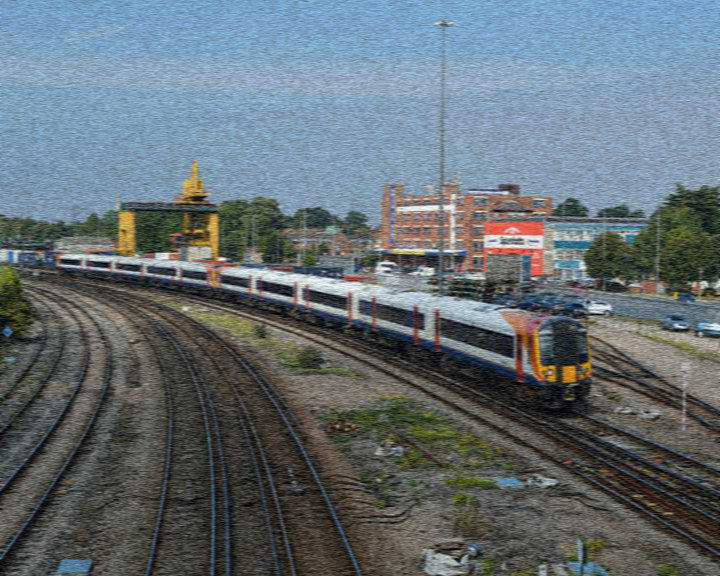

In [7]:
img = Image.open(DATASETS_PATH+"clean_base/000000000071.jpg")

imga = np.interp(np.array(img).astype("float64"), (0,255), (0,1))
imgn = apply_noise(imga)
Image.fromarray(np.interp(imgn,(0,1), (0,255)).astype("uint8"))

In [27]:
def isolate_images(imga, img_name, n_neighbours=20):
    print("Isolating images with {} neighbours pixels".format(n_neighbours))
    inp = np.zeros((
        imga.shape[0] + (2*n_neighbours),
        imga.shape[1] + (2*n_neighbours),
        3
    ))
    inp[n_neighbours:-n_neighbours, n_neighbours:-n_neighbours, :] = imga
    isolated = 0
    print("Isolating 0/{} isolated pixels and neighbors".format(imga.shape[0]*imga.shape[1]), end="", flush=True)
    for x in range(n_neighbours,n_neighbours+imga.shape[0]-1):
        for y in range(n_neighbours,n_neighbours+imga.shape[1]-1):
            out = inp[
                x-n_neighbours:x+n_neighbours,
                y-n_neighbours:y+n_neighbours
            ]
            final_img = Image.fromarray(np.interp(out,(0,1), (0,255)).astype("uint8"))
            final_img.save(join(isolated_out,"{}_{}_{}.png".format(img_name, x, y)))
            isolated += 1
            if isolated % 10 == 0:
                print("\rIsolating {}/{} isolated pixels and neighbors".format(isolated, imga.shape[0]*imga.shape[1]), end="", flush=True)
    print("")

img = Image.open(DATASETS_PATH+"clean_base/000000000072.jpg")
imga = np.interp(np.array(img).astype("float64"), (0,255), (0,1))
imgn = apply_noise(imga)
isolate_images(imgn, "000000000072", n_neighbours=NEIGHBOURS)

Isolating images with 20 neighbours pixels
Isolating 413420/414720 isolated pixels and neighbors


In [16]:
y = imga.reshape(-1,3)
display(y.shape)

(414720, 3)

In [9]:
pixel_files = !ls ../labs/noise-filter/noisy_isolated

In [10]:
def infer_metadata(filenames):
    full_filename = np.char.split(filenames, ".")
    full_filename = np.array([i[0] for i in full_filename])
    meta = np.char.split(full_filename,"_")
    meta = np.array([np.array(i) for i in meta])
    return meta

In [11]:
shuffled_files = np.random.permutation(pixel_files)
train_batch = shuffled_files[:75_000]
test_batch = shuffled_files[75_001:][:1_0000]

display(train_batch[:10])
display(test_batch[:10])

array(['000000000071_557_428.png', '000000000071_203_725.png',
       '000000000071_126_55.png', '000000000071_407_276.png',
       '000000000071_461_25.png', '000000000071_99_641.png',
       '000000000071_245_99.png', '000000000071_561_373.png',
       '000000000071_553_65.png', '000000000071_36_256.png'], dtype='<U24')

array(['000000000071_63_116.png', '000000000071_244_559.png',
       '000000000071_444_318.png', '000000000071_50_549.png',
       '000000000071_475_577.png', '000000000071_183_656.png',
       '000000000071_66_144.png', '000000000071_375_235.png',
       '000000000071_104_119.png', '000000000071_354_484.png'],
      dtype='<U24')

In [30]:
def get_data(images_filenames):
    X = []
    y = []
    
    metadata_list = infer_metadata(images_filenames)
    
    source_uniq = np.unique(metadata_list[:,0])
    source_img_dict = dict()
    print("Loading Source images 0/{} images".format(source_uniq.shape[0]), end="", flush=True)
    for i, source_img in enumerate(source_uniq):
        img = Image.open(join(source_path, source_img+".jpg"))
        source_img_dict[source_img] = np.interp(np.array(img).astype("float64"), (0,255), (0,1))
        print("\rLoading Source images {}/{} images".format(i+1,source_uniq.shape[0]), end="", flush=True)
    
    print("")
    
    loaded = 0
    print("Loading data {}/{} images".format(loaded,images_filenames.shape[0]), end="", flush=True)
    for meta, filename in zip(metadata_list, images_filenames):
        img = Image.open(join(isolated_out, filename))
        imga = np.interp(np.array(img).astype("float64"), (0,255), (0,1))
        source = source_img_dict[meta[0]]
        if int(meta[1]) < source.shape[0] and int(meta[2]) < source.shape[1]:
            y += [source[int(meta[1]), int(meta[2])]]
            X += [imga.flatten()]
            loaded += 10
        else:
            print("\nImage {} is out of bound of the source image {}".format(filename, meta[0]+".jpg"))
        if loaded % 10 == 0 :
            print("\rLoading data {}/{} images".format(loaded,images_filenames.shape[0]), end="", flush=True)
    print("")
    return (np.array(X), np.array(y))

In [31]:
%%time
X, y = get_data(train_batch)
X_test, y_test = get_data(test_batch)

Loading Source images 1/1 images
Loading data 10/75000 images
Image 000000000071_203_725.png is out of bound of the source image 000000000071.jpg
Loading data 100/75000 images
Image 000000000071_581_292.png is out of bound of the source image 000000000071.jpg
Loading data 170/75000 images

FileNotFoundError: [Errno 2] No such file or directory: '../labs/noise-filter/noisy_isolated/000000000071_599_593.png'

In [ ]:
display(X)
display(y)

## Modèle de Machine learning

L'objectif dans cette partie est de trouver un modèle de Machine Learning permettant de prédire la couleur d'un pixel (3 features) en prenant en compte ses voisins.
Pour ce faire, nous allons tenter de créer un Multioutput Regressor sur la base d'un Stochastic Gradient Decent.

In [ ]:
reg = MultiOutputRegressor(SGDRegressor(), n_jobs=-1)
reg.fit(X,y)

In [ ]:
y_predict = reg.predict(X_test)
mean_squared_error(y_test,y_predict)

In [ ]:
show_img(X[0].reshape(40,40,3))
display(y[0])

In [17]:
def predict_image(reg, imga, single_input=False, n_neighbours=20):
    predicted = np.zeros(imga.shape)
    inp = np.zeros((
        imga.shape[0] + (2*n_neighbours),
        imga.shape[1] + (2*n_neighbours),
        3
    ))
    inp[n_neighbours:-n_neighbours, n_neighbours:-n_neighbours, :] = imga
    for x in range(n_neighbours,n_neighbours+imga.shape[0]-1):
        for y in range(n_neighbours,n_neighbours+imga.shape[1]-1):
            out = inp[
                x-n_neighbours:x+n_neighbours,
                y-n_neighbours:y+n_neighbours
            ]
            predicted[x-n_neighbours][y-n_neighbours] = reg.predict(np.array([out.flatten()]))[0]
    return predicted

In [ ]:
show_img(predict_image(reg, imgn, n_neighbours=NEIGHBOURS))

Hum... Il semble que ce soit pas tellement le résultat escompté. Nous allons tester avec un réseau de neurones.

In [23]:
X.shape

(69442, 7500)

In [28]:
model = Sequential([
    Dense(20, input_shape=(NEIGHBOURS*NEIGHBOURS*4*3,), activation="relu"),
    Dense(10, activation='relu'),
    Dense(3, activation="relu")
])
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                96020     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 33        
Total params: 96,263
Trainable params: 96,263
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X, y, epochs=20)

ValueError: Error when checking input: expected dense_6_input to have shape (4800,) but got array with shape (7500,)

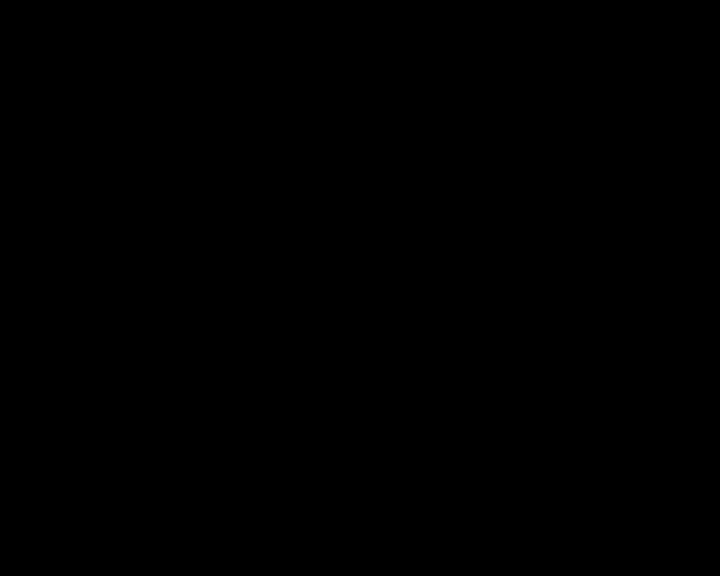

In [22]:
show_img(predict_image(model, imgn, n_neighbours=NEIGHBOURS))

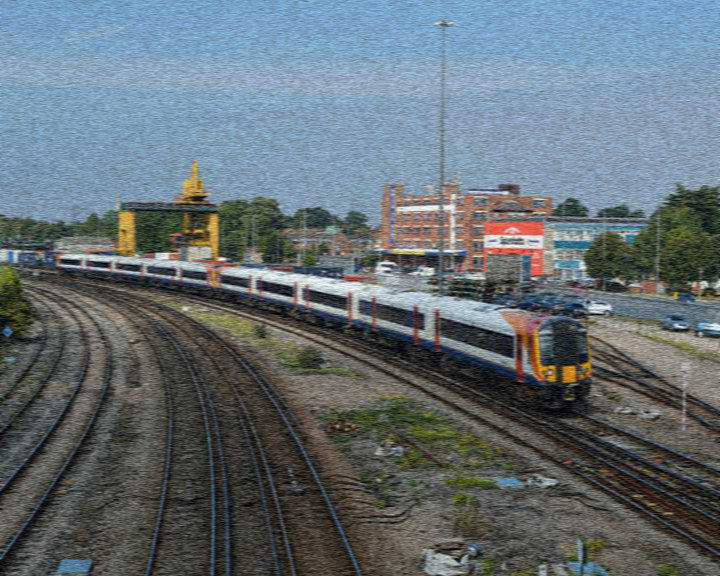

In [23]:
show_img(imgn)

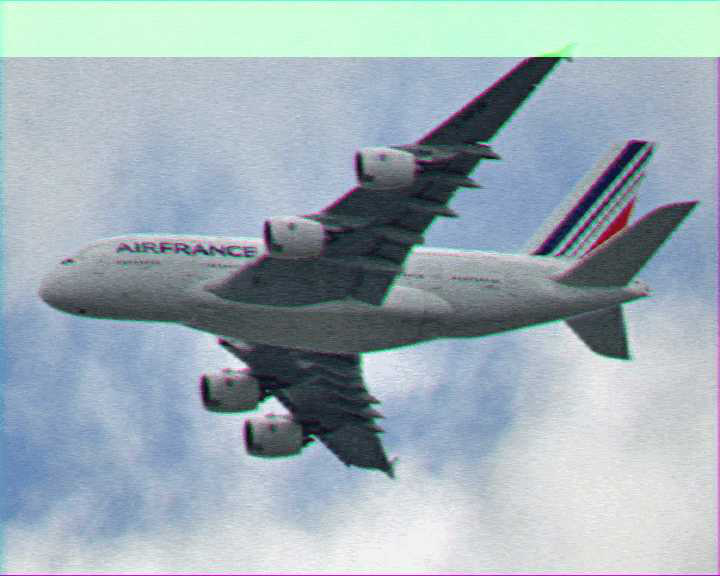

In [28]:
test_img = Image.open("../dataset_clean_degraded/degraded/000000000081.jpg")
test_imga = np.interp(np.array(test_img).astype("float64"), (0,255), (0,1))
show_img(test_imga)

In [ ]:
show_img(predict_image(model, test_imga, n_neighbours=NEIGHBOURS))

In [ ]:
test_img = Image.open("../dataset_clean_degraded/degraded/000000033431.jpg")
test_imga = np.interp(np.array(test_img).astype("float64"), (0,255), (0,1))
show_img(test_imga)

In [ ]:
show_img(predict_image(model, test_imga, n_neighbours=NEIGHBOURS))